In [1]:
import os
from dotenv import load_dotenv
from typing import Dict, List, Any, Optional, Annotated, Union, Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage, ToolMessage, filter_messages
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import MessagesState

from langgraph.prebuilt import tools_condition, ToolNode

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langgraph.errors import NodeInterrupt

from IPython.display import Image, display

In [2]:
load_dotenv()

True

In [3]:
db = SQLDatabase.from_uri("sqlite:///../sql-support-bot/chinook.db")
print(db.get_usable_table_names())

['albums', 'artists', 'customers', 'employees', 'genres', 'invoice_items', 'invoices', 'media_types', 'playlist_track', 'playlists', 'tracks']


In [4]:
os.environ["LANGCHAIN_PROJECT"] = "music-store-support-demo-prep"

# Set up LLMs, state and interrupt messages

In [5]:
helpdesk_agent_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
account_agent_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
music_recommendation_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

In [6]:
class MusicStoreChatbotState(MessagesState):
    customer_id: Optional[int]
    current_mode: Literal["router", "account", "music"]

In [7]:
customer_id_interrupt_message = "Please provide your customer ID to help me assist you better."
action_confirmation_interrupt_message = "This action will update the database. Please confirm that you want to proceed (yes/no)"

# Helper Functions

In [8]:
def get_last_human_message(messages: List[BaseMessage]) -> Optional[HumanMessage]:
    """Extract the last human message from the conversation history."""
    for message in reversed(messages):
        if isinstance(message, HumanMessage):
            return message
    return None

# Music Recommendation Agent

## Create Artist and Song retrievers to allow inexact matching of for artists and tracks/songs names

In [9]:
artists = db._execute("SELECT * FROM artists")
songs = db._execute("SELECT * FROM tracks")
artist_retriever = SKLearnVectorStore.from_texts(
    [a['Name'] for a in artists],
    OpenAIEmbeddings(),
    metadatas=artists
).as_retriever()


song_retriever = SKLearnVectorStore.from_texts(
    [a['Name'] for a in songs],
    OpenAIEmbeddings(),
    metadatas=songs
).as_retriever()

## Define Tools to get recommendations

### Tools not specific to a customer

In [10]:
@tool
def get_albums_by_artist(artist: str):
    """Get albums by an artist (or similar artists)."""
    docs = artist_retriever.get_relevant_documents(artist)
    artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
    return db.run(
        f"SELECT Title, Name as ArtistName FROM albums LEFT JOIN artists ON albums.ArtistId = artists.ArtistId WHERE albums.ArtistId in ({artist_ids});",
        include_columns=True)


@tool
def get_tracks_by_artist(artist: str):
    """Get songs by an artist (or similar artists)."""
    docs = artist_retriever.get_relevant_documents(artist)
    artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
    return db.run(
        f"SELECT tracks.Name as SongName, artists.Name as ArtistName FROM albums LEFT JOIN artists ON albums.ArtistId = artists.ArtistId LEFT JOIN tracks ON tracks.AlbumId = albums.AlbumId WHERE albums.ArtistId in ({artist_ids});",
        include_columns=True)


@tool
def search_songs(song_title: str):
    """Search for songs by title."""
    docs = song_retriever.get_relevant_documents(song_title)
    return [{"Title": doc.page_content, "TrackId": doc.metadata["TrackId"]} for doc in docs[:5]]


@tool
def get_similar_music(genre: str, artist: str = ""):
    """Get music recommendations based on genre and optionally artist."""
    # Find genre ID
    genre_query = f"""
    SELECT GenreId FROM genres 
    WHERE Name LIKE '%{genre}%' 
    LIMIT 1
    """
    genre_result = db.run(genre_query)
    if not genre_result:
        return f"No genre found matching '{genre}'"

    # Genre result comes as a string like "[(1,)]" - parse it
    genre_id = int(genre_result.strip("[]() \t\n,").split(",")[0])

    # Get tracks in that genre, optionally filtering by artist
    artist_filter = ""
    if artist:
        docs = artist_retriever.get_relevant_documents(artist)
        if docs:
            artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
            artist_filter = f"AND albums.ArtistId IN ({artist_ids})"
    
    query = f"""
    SELECT tracks.Name as TrackName, artists.Name as ArtistName, albums.Title as AlbumTitle
    FROM tracks
    JOIN albums ON tracks.AlbumId = albums.AlbumId
    JOIN artists ON albums.ArtistId = artists.ArtistId
    WHERE tracks.GenreId = {genre_id} {artist_filter}
    ORDER BY RANDOM()
    LIMIT 5
    """
    
    result = db.run(query, include_columns=True)
    
    # Format the result nicely for display
    if not result:
        return f"No songs found for genre '{genre}'" + (f" and artist '{artist}'" if artist else "")
    
    formatted_result = "Here are some similar tracks:\n\n"
    for track in result:
        formatted_result += f"- {track['TrackName']} by {track['ArtistName']} (Album: {track['AlbumTitle']})\n"
    
    return formatted_result
    

### Tools specific to a customer

In [11]:
@tool
def get_customer_top_genres(customer_id: int, limit: int = 5):
    """Identify a customer's favorite genres based on purchase history."""
    return db.run(f"""
        SELECT g.Name as Genre, COUNT(ii.InvoiceLineId) as PurchaseCount
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN genres g ON t.GenreId = g.GenreId
        WHERE i.CustomerId = {customer_id}
        GROUP BY g.GenreId
        ORDER BY PurchaseCount DESC
        LIMIT {limit};
    """, include_columns=True)

@tool
def get_customer_top_artists(customer_id: int, limit: int = 5):
    """Identify a customer's favorite artists based on purchase history."""
    return db.run(f"""
        SELECT ar.Name as Artist, COUNT(ii.InvoiceLineId) as PurchaseCount,
               SUM(ii.UnitPrice) as TotalSpent
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE i.CustomerId = {customer_id}
        GROUP BY ar.ArtistId
        ORDER BY PurchaseCount DESC
        LIMIT {limit};
    """, include_columns=True)

@tool
def check_track_purchase_history(customer_id: int, track_name: str):
    """Check if and when a customer purchased a specific track."""
    # First, find tracks that match the provided name
    docs = song_retriever.get_relevant_documents(track_name)
    if not docs:
        return f"No tracks found matching '{track_name}'"
    
    track_ids = ", ".join([str(doc.metadata['TrackId']) for doc in docs[:5]])
    
    return db.run(f"""
        SELECT i.InvoiceDate, t.Name as TrackName, ar.Name as Artist, 
               al.Title as Album, ii.UnitPrice
        FROM invoices i
        JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE i.CustomerId = {customer_id} AND t.TrackId IN ({track_ids})
        ORDER BY i.InvoiceDate DESC;
    """, include_columns=True)

@tool
def get_recommended_tracks_from_purchase_history(customer_id: int, limit: int = 5):
    """Get personalized track recommendations based on purchase history."""
    # First, get the customer's top genres
    top_genres_query = """
        SELECT g.Name as Genre
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN genres g ON t.GenreId = g.GenreId
        WHERE i.CustomerId = {customer_id}
        GROUP BY g.GenreId
        ORDER BY COUNT(ii.InvoiceLineId) DESC
        LIMIT 2;
    """.format(customer_id=customer_id)
    
    genres_result = db.run(top_genres_query, include_columns=True)
    
    if not genres_result:
        return "No purchase history found to base recommendations on."
    
    # Get customer's purchased tracks to exclude them
    purchased_tracks_query = """
        SELECT t.TrackId
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        WHERE i.CustomerId = {customer_id};
    """.format(customer_id=customer_id)
    
    purchased_tracks_result = db.run(purchased_tracks_query)
    purchased_track_ids = []
    if purchased_tracks_result:
        # Extract track IDs from the SQL result
        for row in purchased_tracks_result.strip('[]').split('), ('):
            track_id = row.strip('()').split(',')[0]
            if track_id.isdigit():
                purchased_track_ids.append(int(track_id))
    
    # Get top artists (optional enhancement)
    top_artist_query = """
        SELECT ar.Name as Artist
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE i.CustomerId = {customer_id}
        GROUP BY ar.ArtistId
        ORDER BY COUNT(ii.InvoiceLineId) DESC
        LIMIT 1;
    """.format(customer_id=customer_id)
    
    artist_result = db.run(top_artist_query, include_columns=True)
    top_artist = artist_result[0]['Artist'] if artist_result else ""
    
    # Use the existing get_similar_music with the top genre
    recommendations = get_similar_music(genres_result[0]['Genre'], top_artist)
    
    # You could filter out already purchased tracks here if needed
    
    return recommendations


@tool
def summarize_music_taste(customer_id: int):
    """Provide a data summary of the customer's music taste based on purchase history."""
    print(f"~~~~~~~~ In summarize_music_taste, {customer_id}")
    summary_query = f"""
    SELECT 
        (SELECT COUNT(DISTINCT ar.ArtistId) FROM invoice_items ii 
         JOIN invoices i ON ii.InvoiceId = i.InvoiceId
         JOIN tracks t ON ii.TrackId = t.TrackId
         JOIN albums al ON t.AlbumId = al.AlbumId
         JOIN artists ar ON al.ArtistId = ar.ArtistId
         WHERE i.CustomerId = {customer_id}) as UniqueArtists,
        
        (SELECT COUNT(DISTINCT g.GenreId) FROM invoice_items ii 
         JOIN invoices i ON ii.InvoiceId = i.InvoiceId
         JOIN tracks t ON ii.TrackId = t.TrackId
         JOIN genres g ON t.GenreId = g.GenreId
         WHERE i.CustomerId = {customer_id}) as UniqueGenres,
        
        (SELECT COUNT(ii.InvoiceLineId) FROM invoice_items ii 
         JOIN invoices i ON ii.InvoiceId = i.InvoiceId
         WHERE i.CustomerId = {customer_id}) as TotalTracks,
        
        (SELECT SUM(i.Total) FROM invoices i 
         WHERE i.CustomerId = {customer_id}) as TotalSpent
    """
    
    stats = db.run(summary_query, include_columns=True)
    
    if not stats:
        return "No purchase history found for this customer."

    # Get top genres string
    top_genres = get_customer_top_genres(customer_id, 3)
    genre_str = ", ".join([g['Genre'] for g in top_genres]) if top_genres else "None found"

    # Get top artists string
    top_artists = get_customer_top_artists(customer_id, 3)
    artist_str = ", ".join([a['Artist'] for a in top_artists]) if top_artists else "None found"

    return {
        "stats": stats,
        "top_genres": genre_str,
        "top_artists": artist_str
    }

In [12]:
music_recommendation_tools = [
    get_albums_by_artist,
    get_tracks_by_artist,
    search_songs,
    get_similar_music,
    get_customer_top_genres,
    get_customer_top_artists,
    check_track_purchase_history,
    get_recommended_tracks_from_purchase_history,
    summarize_music_taste
]
music_recommendation_model_with_tools = music_recommendation_model.bind_tools(music_recommendation_tools)

## Set up graph

### Node to process queries

In [13]:
music_system_message = """You are a music specialist at a music store.
You have extensive knowledge of our music catalog and can assist customers in discovering music they'll love.

FOR ALL CUSTOMERS, YOU CAN:
1. Find albums by specific artists
2. List songs by an artist
3. Search for specific tracks by name
4. Recommend music based on genres or similar artists

FOR AUTHENTICATED CUSTOMERS (when a customer ID is provided), YOU CAN ALSO:
5. Check their purchase history for specific tracks or artists
6. Analyze their music taste based on previous purchases
7. Provide personalized recommendations based on their top genres
8. Suggest new music similar to their favorite artists
9. Summarize their music preferences with insights about their taste

GUIDELINES:
- Be conversational and show enthusiasm about music
- If you can't find exactly what they're looking for, suggest similar alternatives
- When making recommendations, briefly explain why you think they might enjoy them
- For customers with limited purchase history, balance personalized suggestions with popular recommendations
- Use specific examples when discussing artists and genres
- If asked about a purchase they can't recall, offer to check their purchase history

Your goal is to help customers discover music they'll love, whether they're looking for specific tracks or open to new recommendations that match their taste.
"""


def handle_music_query(state: MusicStoreChatbotState):
    """Handle music-related queries"""
    
    messages = [SystemMessage(content=music_system_message)]
    context_messages = filter_messages(state["messages"], exclude_types="system")
    # context_messages = state["messages"][-5:] if len(state["messages"]) > 5 else state["messages"]
    messages.extend(context_messages)

    # Let the agent determine what to do next
    response = music_recommendation_model_with_tools.invoke(messages)

    return {
        "messages": state["messages"] + [response]
    }

### Graph Definition

In [14]:
music_recommendation_graph_builder = StateGraph(MusicStoreChatbotState)

music_recommendation_graph_builder.add_node("handle_music_query", handle_music_query)
music_recommendation_graph_builder.add_node("tools", ToolNode(music_recommendation_tools))

# Add the starting edge
music_recommendation_graph_builder.add_edge(START, "handle_music_query")
music_recommendation_graph_builder.add_conditional_edges(
    "handle_music_query",
    # If the latest message from assistant 
    # is a tool call -> tools_condition routes to tools
    # is a not a tool call -> tools_condition routes to END
    tools_condition,
)
music_recommendation_graph_builder.add_edge("tools", "handle_music_query")
music_recommendation_graph_builder.add_edge("handle_music_query", END)

music_recommendation_memory = MemorySaver()
# Can hard-code interruptions  using `builder.compile(interrupt_before=["tools"], checkpointer=memory)`
music_recommendation_graph = music_recommendation_graph_builder.compile(checkpointer=music_recommendation_memory)

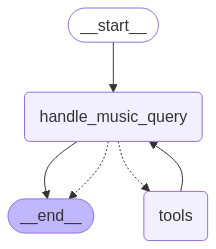

In [15]:
display(Image(music_recommendation_graph.get_graph().draw_mermaid_png()))

## Test

In [16]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "1"}}

# Then use it in your invoke call
response = music_recommendation_graph.invoke(
    {"messages": [HumanMessage(content="Hey, recommend music by Amy Winehouse")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

for m in response["messages"]:
    m.pretty_print()

/var/folders/h0/6_6mqq755ks82f6p8nvrzqlr0000gn/T/ipykernel_6253/2826969327.py:4: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = artist_retriever.get_relevant_documents(artist)


================================ Human Message =================================

Hey, recommend music by Amy Winehouse
================================== Ai Message ==================================
Tool Calls:
  get_albums_by_artist (call_kaQjpXCNEQUVVBL8hYreVtJO)
 Call ID: call_kaQjpXCNEQUVVBL8hYreVtJO
  Args:
    artist: Amy Winehouse
================================= Tool Message =================================
Name: get_albums_by_artist

[{'Title': 'Jagged Little Pill', 'ArtistName': 'Alanis Morissette'}, {'Title': 'Audioslave', 'ArtistName': 'Audioslave'}, {'Title': 'Out Of Exile', 'ArtistName': 'Audioslave'}, {'Title': 'Revelations', 'ArtistName': 'Audioslave'}, {'Title': 'Bark at the Moon (Remastered)', 'ArtistName': 'Ozzy Osbourne'}, {'Title': 'Blizzard of Ozz', 'ArtistName': 'Ozzy Osbourne'}, {'Title': 'Diary of a Madman (Remastered)', 'ArtistName': 'Ozzy Osbourne'}, {'Title': 'No More Tears (Remastered)', 'ArtistName': 'Ozzy Osbourne'}, {'Title': 'Tribute', 'ArtistName':

In [17]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "2"}}

# Then use it in your invoke call
response = music_recommendation_graph.invoke(
    {"messages": [HumanMessage(content="Hey, recommend songs by Green Day")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hey, recommend songs by Green Day
================================== Ai Message ==================================
Tool Calls:
  get_tracks_by_artist (call_EUTprRZtiKp4SUMws3jtaDhm)
 Call ID: call_EUTprRZtiKp4SUMws3jtaDhm
  Args:
    artist: Green Day
================================= Tool Message =================================
Name: get_tracks_by_artist

[{'SongName': 'Maria', 'ArtistName': 'Green Day'}, {'SongName': 'Poprocks And Coke', 'ArtistName': 'Green Day'}, {'SongName': 'Longview', 'ArtistName': 'Green Day'}, {'SongName': 'Welcome To Paradise', 'ArtistName': 'Green Day'}, {'SongName': 'Basket Case', 'ArtistName': 'Green Day'}, {'SongName': 'When I Come Around', 'ArtistName': 'Green Day'}, {'SongName': 'She', 'ArtistName': 'Green Day'}, {'SongName': 'J.A.R. (Jason Andrew Relva)', 'ArtistName': 'Green Day'}, {'SongName': 'Geek Stink Breath', 'ArtistName': 'Green Day'}, {'SongName': 'Brain Stew',

In [18]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "3"}}

# Then use it in your invoke call
response = music_recommendation_graph.invoke(
    {"messages": [HumanMessage(content="Hey, is Boulevard Of Broken Dreams available for purchase?")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hey, is Boulevard Of Broken Dreams available for purchase?
================================== Ai Message ==================================
Tool Calls:
  search_songs (call_HzKtl76AphIhPVBhWHvPWgPf)
 Call ID: call_HzKtl76AphIhPVBhWHvPWgPf
  Args:
    song_title: Boulevard Of Broken Dreams
================================= Tool Message =================================
Name: search_songs

[{"Title": "Boulevard Of Broken Dreams", "TrackId": 1136}, {"Title": "City Of Blinding Lights", "TrackId": 2968}, {"Title": "Under The Bridge", "TrackId": 2368}, {"Title": "Where The Streets Have No Name", "TrackId": 3010}]
================================== Ai Message ==================================

Yes, "Boulevard Of Broken Dreams" is available for purchase! If you're interested, I can help you with the next steps to get it. Would you like to know more about the artist or similar songs?


In [19]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "400"}}

# Then use it in your invoke call
response = music_recommendation_graph.invoke(
    {"messages": [HumanMessage(content="Hey, I like Boulevard Of Broken Dreams. What other albums and songs would you recommend?")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hey, I like Boulevard Of Broken Dreams. What other albums and songs would you recommend?
================================== Ai Message ==================================
Tool Calls:
  search_songs (call_EQDRRlELWj07FetOD3nX6dF3)
 Call ID: call_EQDRRlELWj07FetOD3nX6dF3
  Args:
    song_title: Boulevard Of Broken Dreams
  get_similar_music (call_FZJITFjKDgQNBA0BmvtXmtU6)
 Call ID: call_FZJITFjKDgQNBA0BmvtXmtU6
  Args:
    genre: Rock
    artist: Green Day
================================= Tool Message =================================
Name: search_songs

[{"Title": "Boulevard Of Broken Dreams", "TrackId": 1136}, {"Title": "City Of Blinding Lights", "TrackId": 2968}, {"Title": "Under The Bridge", "TrackId": 2368}, {"Title": "Where The Streets Have No Name", "TrackId": 3010}]
================================= Tool Message =================================
Name: get_similar_music

Error: TypeError("string indi

# Account Agent

## Set up graph

### Tools

#### Tools for customer profile

In [20]:
@tool
def query_customer_info(customer_id: int):
    """Look up customer info given their ID. Requires customer authentication."""
    print("-" * 50)
    print(f"query_customer_info called with {customer_id}")
    return db.run(f"SELECT * FROM customers WHERE CustomerId = {customer_id};")

@tool
def update_customer_info(customer_id: int, field: str, value: str) -> str:
    """
    Update a customer's information.
    - customer_id: The ID of the customer to update
    - field: The field to update (FirstName, LastName, Company, Address, City, State, Country, PostalCode, Phone, Email)
    - value: The new value for the field
    - confirmed: Has the user confirmed that they want to proceed?
    """
    print("-" * 50)
    print(f"update_customer_info called with {customer_id}")
    allowed_fields = ["FirstName", "LastName", "Company", "Address", "City", 
                       "State", "Country", "PostalCode", "Phone", "Email"]

    if field not in allowed_fields:
        return f"Error: Cannot update field '{field}'. Allowed fields are: {', '.join(allowed_fields)}"

    # Verify customer exists first
    customer = db.run(f"SELECT * FROM customers WHERE CustomerId = {customer_id};")
    if not customer:
        return f"Error: No customer found with ID {customer_id}"

    try:
        # Sanitize the value to prevent SQL injection
        sanitized_value = value.replace("'", "''")  # Double up single quotes for SQL safety
        
        # Execute the actual update query
        update_query = f"UPDATE customers SET {field} = '{sanitized_value}' WHERE CustomerId = {customer_id};"
        db.run(update_query)
        
        # Simply assume success if no exceptions occurred
        return f"Successfully updated {field} to '{value}' for customer {customer_id}"
    
    except Exception as e:
        return f"Error updating database: {str(e)}"

#### Tools for customer transactions

In [21]:
@tool
def get_customer_invoices(customer_id: int, limit: int = 10):
    """Retrieve the most recent invoices for a customer."""
    print("-" * 50)
    print(f"get_customer_invoices called with {customer_id}")
    return db.run(f"""
        SELECT InvoiceId, InvoiceDate, Total 
        FROM invoices 
        WHERE CustomerId = {customer_id}
        ORDER BY InvoiceDate DESC
        LIMIT {limit};
    """, include_columns=True)

@tool
def get_invoice_details(invoice_id: int):
    """Get detailed line items for a specific invoice."""
    print("-" * 50)
    print(f"get_invoice_details called with {invoice_id}")
    return db.run(f"""
        SELECT ii.InvoiceLineId, t.Name as TrackName, 
               ar.Name as ArtistName, al.Title as AlbumTitle,
               ii.UnitPrice, ii.Quantity
        FROM invoice_items ii
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE ii.InvoiceId = {invoice_id}
        ORDER BY ii.InvoiceLineId;
    """, include_columns=True)

@tool
def get_spending_history(customer_id: int, start_date: str = None, end_date: str = None):
    """Get a customer's spending history, optionally within a date range."""
    date_filter = ""
    if start_date and end_date:
        date_filter = f"AND InvoiceDate BETWEEN '{start_date}' AND '{end_date}'"
    elif start_date:
        date_filter = f"AND InvoiceDate >= '{start_date}'"
    elif end_date:
        date_filter = f"AND InvoiceDate <= '{end_date}'"
    
    return db.run(f"""
        SELECT strftime('%Y-%m', InvoiceDate) as Month, 
               SUM(Total) as MonthlyTotal,
               COUNT(InvoiceId) as PurchaseCount
        FROM invoices
        WHERE CustomerId = {customer_id} {date_filter}
        GROUP BY strftime('%Y-%m', InvoiceDate)
        ORDER BY Month DESC;
    """, include_columns=True)

@tool
def get_recent_purchases(customer_id: int, limit: int = 5):
    """Get the most recent purchases for quick reference."""
    query = f"""
        SELECT i.InvoiceDate, t.Name as TrackName, ar.Name as Artist,
               ii.UnitPrice
        FROM invoices i
        JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE i.CustomerId = {customer_id}
        ORDER BY i.InvoiceDate DESC
        LIMIT {limit};
    """
    return db.run(query, include_columns=True)


@tool
def check_purchase_history(customer_id: int, date_from: str = None, date_to: str = None, 
                          track_name: str = None, artist_name: str = None, album_title: str = None):
    """
    Check purchase history with flexible filtering options.
    Provide at least one filter parameter (date range, track, artist, or album).
    """
    # Build WHERE clause based on provided parameters
    filters = [f"i.CustomerId = {customer_id}"]
    
    if date_from:
        filters.append(f"i.InvoiceDate >= '{date_from}'")
    if date_to:
        filters.append(f"i.InvoiceDate <= '{date_to}'")
        
    # Use retrievers for fuzzy matching where appropriate
    track_filter = ""
    if track_name:
        docs = song_retriever.get_relevant_documents(track_name)
        if docs:
            track_ids = ", ".join([str(doc.metadata['TrackId']) for doc in docs[:5]])
            filters.append(f"t.TrackId IN ({track_ids})")
    
    artist_filter = ""
    if artist_name:
        docs = artist_retriever.get_relevant_documents(artist_name)
        if docs:
            artist_ids = ", ".join([str(doc.metadata['ArtistId']) for doc in docs[:5]])
            filters.append(f"ar.ArtistId IN ({artist_ids})")
    
    if album_title:
        filters.append(f"al.Title LIKE '%{album_title}%'")
    
    where_clause = " AND ".join(filters)
    
    query = f"""
        SELECT i.InvoiceDate, t.Name as TrackName, ar.Name as Artist, 
               al.Title as Album, ii.UnitPrice
        FROM invoices i
        JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE {where_clause}
        ORDER BY i.InvoiceDate DESC
        LIMIT 20;
    """
    
    return db.run(query, include_columns=True)

In [22]:
account_query_tool_names = ["query_customer_info"]
account_query_tools = [
    query_customer_info, 
    get_customer_invoices, 
    get_invoice_details, 
    get_spending_history, 
    get_recent_purchases, 
    check_purchase_history
]
account_update_tool_names = ["update_customer_info"]
account_update_tools = [update_customer_info]

In [23]:
# account_agent_model_with_tools = account_agent_model.bind_tools(tools=account_query_tools + account_update_tools)

### Node: Process Account Query

In [24]:
account_agent_prompt = """You are a customer account specialist at a music store.
Your task is to ANALYZE customer requests and CLASSIFY them as either QUERY or UPDATE:

QUERY requests:
- Retrieving account information (name, contact details, address)
- Viewing purchase history
- Finding specific purchases
- Checking invoice details
- Examining spending history

UPDATE requests:
- Changing email address
- Updating contact information
- Modifying personal details
- Changing address
- Updating any profile information

DO NOT actually perform the query or update. Your job is ONLY to:
1. Understand what the customer is asking for
2. Respond with confirmation of what you'll help with
3. Indicate what specific information you'll check or what specific field you'll update

EXAMPLES:
Customer: "Can you tell me my account details?"
You: "I'll help you check your account details. Let me retrieve that information for you."

Customer: "I want to change my email to newemail@example.com"
You: "I'll help you update your email address to newemail@example.com. Let me process that change for you."

Always be professional, clear about what you're going to do, and confirm any specific details mentioned by the customer.
"""

summarization_prompt = """You are a customer service representative at a music store.
Your task is to translate technical tool results into natural, friendly language.

Given a tool result, create a response that:
1. Confirms what was done (for updates) or what was found (for queries)
2. Presents the information in a clear, organized way
3. Offers relevant follow-up assistance if appropriate

For query results:
- Format information for readability
- Highlight key details
- If the result is empty, kindly explain no information was found

For update results:
- Confirm the specific change that was made
- Mention which field was updated and to what value
- Express success or explain any issues encountered

Always maintain a helpful, professional tone. Avoid technical jargon unless explaining an error.
"""

In [25]:
def account_agent(state: MusicStoreChatbotState):
    """Determine if the request is a query or update, without executing it."""
    customer_id = state["customer_id"]
    
    # Build messages for the account agent
    messages = [SystemMessage(content=account_agent_prompt)]
    context_messages = state["messages"][-5:] if len(state["messages"]) > 5 else state["messages"]
    messages.extend(context_messages)
    messages.append(SystemMessage(content=f"Current authenticated customer ID: {customer_id}"))
    
    # Agent analyzes request
    response = account_agent_model.invoke(messages)
    
    # Determine action type from response
    action_type = "query"  # Default
    if any(update_term in response.content.lower() for update_term in 
           ["update", "change", "modify", "edit", "alter"]):
        action_type = "update"
    
    return {
        "messages": state["messages"] + [response],
        "action_type": action_type,
        "customer_id": customer_id
    }

def action_type_router(state: MusicStoreChatbotState) -> str:
    """Route based on action type"""
    return state["action_type"]

def process_results(state: MusicStoreChatbotState):
    """Process tool results and generate natural language summary"""
    # Extract the latest tool message (should be the tool result)
    tool_messages = filter_messages(state["messages"], include_types="tool")
    tool_result = tool_messages[-1] if tool_messages else None
    
    if not tool_result:
        return {
            "messages": state["messages"] + [AIMessage(content="I couldn't process your request. Please try again.")]
        }
    
    # Build context for summarization
    summarization_messages = [
        SystemMessage(content=summarization_prompt),
        SystemMessage(content=f"Tool result: {tool_result.content}"),
        SystemMessage(content="Please summarize this result in a helpful, natural way.")
    ]
    
    # Generate summary
    summary = account_agent_model.invoke(summarization_messages)
    
    return {
        "messages": state["messages"] + [summary]
    }

### Graph definition

In [26]:
account_agent_graph_builder = StateGraph(MusicStoreChatbotState)
account_agent_memory = MemorySaver()




# Add nodes
account_agent_graph_builder.add_node("account_agent", account_agent)
account_agent_graph_builder.add_node("query_tools", ToolNode(account_query_tools))
account_agent_graph_builder.add_node("update_tools", ToolNode(account_update_tools))
account_agent_graph_builder.add_node("process_results", process_results)

# Add edges
account_agent_graph_builder.add_edge(START, "account_agent")
account_agent_graph_builder.add_edge("query_tools", "process_results")
account_agent_graph_builder.add_edge("update_tools", "process_results")
account_agent_graph_builder.add_edge("process_results", END)

# Add conditional edges
account_agent_graph_builder.add_conditional_edges(
    "account_agent", 
    action_type_router,
    {
        "query": "query_tools",
        "update": "update_tools"
    }
)

# Compile with interruption
account_agent_graph = account_agent_graph_builder.compile(
    interrupt_before=["update_tools"],
    checkpointer=account_agent_memory
)

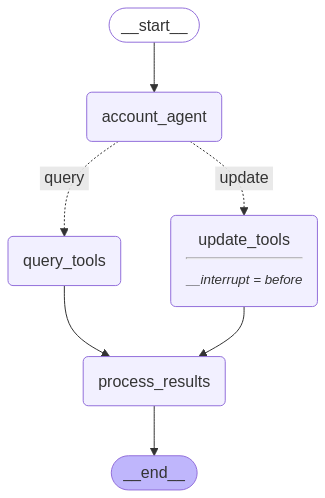

In [27]:
display(Image(account_agent_graph.get_graph().draw_mermaid_png()))

## Test

#### Test fetching account details without providing ID up front

In [28]:
# Input
initial_input = {
    "messages": [HumanMessage(content="I want to check my account details")], 
    "current_mode": "account", 
    "customer_id": 2
}

# Thread
thread = {"configurable": {"thread_id": "customer_id_request_4"}}

# Run the graph - it will stop if an interruption occurs
try:
    for event in account_agent_graph.stream(initial_input, thread, stream_mode="values"):
        # Display messages as they come
        event['messages'][-1].pretty_print()
except Exception as e:
    print(f"Graph execution stopped: {e}")

# Check if there was an interruption
state = account_agent_graph.get_state(thread)
if state.tasks and any(task.interrupts for task in state.tasks):
    # Get the interruption message
    interrupt_task = next(task for task in state.tasks if task.interrupts)
    interrupt_message = interrupt_task.interrupts[0].value
    
    print(f"\nAgent needs more information: {interrupt_message}")
    
    # Get customer ID from user
    customer_id_input = input("Please enter your customer ID: ")
    
    # Validate input
    if customer_id_input.isdigit():
        # Update the state with the provided customer ID
        account_agent_graph.update_state(
            thread,
            {
                "customer_id": int(customer_id_input),
                "current_mode": "account",
                "messages": state.values["messages"] + [
                    HumanMessage(content=f"My customer ID is {customer_id_input}")
                ]
            }
        )
        
        # Continue the graph execution with the updated state
        for event in account_agent_graph.stream(None, thread, stream_mode="values"):
            event['messages'][-1].pretty_print()
    else:
        print("Invalid customer ID. Please enter a numeric ID.")

================================ Human Message =================================

I want to check my account details
================================== Ai Message ==================================

I'll help you check your account details. Let me retrieve that information for you.
================================== Ai Message ==================================

I'll help you check your account details. Let me retrieve that information for you.
================================== Ai Message ==================================

I couldn't process your request. Please try again.


#### Test updating account attribute

In [29]:
# Input
initial_input = {
    # Leonie@kohler.com, leonekohler@surfeu.de
    "messages": [HumanMessage(content="Please update my email to leonekohler@surfeu.de")], 
    "current_mode": "router", 
    "customer_id": 2
}

# Thread
thread = {"configurable": {"thread_id": "12"}}

# Run the graph until the first interruption
for event in account_agent_graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in account_agent_graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

# query_customer_info({"customer_id" : 2})

================================ Human Message =================================

Please update my email to leonekohler@surfeu.de
================================== Ai Message ==================================

I'll help you update your email address to leonekohler@surfeu.de. Let me process that change for you.


Do you want to call the tool? (yes/no):  yes


================================== Ai Message ==================================

I'll help you update your email address to leonekohler@surfeu.de. Let me process that change for you.
================================== Ai Message ==================================

I'll help you update your email address to leonekohler@surfeu.de. Let me process that change for you.
================================== Ai Message ==================================

I couldn't process your request. Please try again.


#### Test response query not related to the account

In [30]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "1"}}

# Then use it in your invoke call
response = account_agent_graph.invoke(
    {"messages": [HumanMessage(content="Hey. recommend music by Amy Winehouse")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hey. recommend music by Amy Winehouse
================================== Ai Message ==================================

I'm here to assist with account-related requests. If you have any questions about your account or need to update your information, please let me know!


# Compound Agent

## Set up graph

### Node: Query decomposition

### Node: Request Routing

In [31]:
derive_id_message = """Your task is to determine the customer ID from text that represents a sequence of 
queries from the user.
For example, 
1. if a query says 'My customer ID is 123' then you should return 123.
2. if the query says 'I want to switch from talking about customer 123 to customer 456', then return 456.
If the customer ID is not part of the query, return UNKNOWN.
For example, if the query is 'Recommend music from U2', return UNKNOWN.

When the sequence represents a conversation, like:
```My customer ID is 123. Recommend music by U2.

What is the most popular song by Green Day?
```
you should be able to determine that the customer ID is 123

Return ONLY the customer ID number, ex. '123' or the string 'UNKNOWN'
"""

router_system_message = """You are a helpful customer support assistant for a music store.
Your job is to determine what the customer needs help with and route them to the appropriate department:

1. ACCOUNT - For updating personal information, account details, or authentication
2. MUSIC - For music recommendations, searching for songs/artists, or questions about music inventory
3. UNRELATED - for anything that does not fit into ACCOUNT or MUSIC

Respond with only the name of the department (ACCOUNT, MUSIC or UNRELATED) that best matches their query.
You are provided the conversation history of the user. Determine the appropriate department based on their
most recent request.
If they want to access personal information and have not provided a customer ID, please ask for the ID.
"""

def get_customer_id_from_history(state: MusicStoreChatbotState) -> str:
    human_messages = filter_messages(state["messages"], include_types="human")
    formatted_human_messages = "\n\n".join([m.content for m in human_messages])
    derived_id_response = helpdesk_agent_model.invoke([SystemMessage(content=derive_id_message)] + human_messages)
    return derived_id_response.content


def route_conversation(state: MusicStoreChatbotState) -> dict:
    """Route the conversation to the appropriate department"""
    state_update = {}  # stores the partial update returned by this function

    # check if the user ID is available in the latest human query
    derived_id = get_customer_id_from_history(state)
    print(f"~~~~~~~ in route_conversation with state: {state}")
    print(derived_id)
    if derived_id.isdigit() and query_customer_info({"customer_id": int(derived_id)}) != "":
        state_update["customer_id"] = int(derived_id)
    elif state["customer_id"] is None:
        raise NodeInterrupt(customer_id_interrupt_message)

    #### QUERY DECOMPOSITION
    # TODO

    #### DECOMPOSED QUERY ROUTING
    # TODO
    
    # ROUTING
    human_messages = filter_messages(state["messages"], include_types="human")
    router_messages = [SystemMessage(content=router_system_message)] + human_messages
    response = helpdesk_agent_model.invoke(router_messages)

    # Update the state with the correct department
    content = response.content.lower()
    if "account" in content:
        state_update["current_mode"] = "account"
    elif "music" in content:
        state_update["current_mode"] = "music"
    else:
        state_update["current_mode"] = "unrelated"

    state_update["messages"] = [SystemMessage(f"Request classified as `{state_update["current_mode"]}`")]
    return state_update


def route_condition(state: MusicStoreChatbotState) -> str:
    """Return the routing condition based on the current state"""
    return state["current_mode"]

### Node: Out of Scope Queries

In [32]:
def out_of_scope_message_node(state: MusicStoreChatbotState):
    """Node that mocks an agent that can respond only with a default message for unrelated queries."""
    response = "I can only help with music recommendations and account updates. Please try again"
    return {
        "messages": state["messages"] + [AIMessage(response)]
    }

### Graph definition

In [33]:
front_desk_graph_builder = StateGraph(MusicStoreChatbotState)
front_desk_graph_builder.add_node("route_conversation", route_conversation)
front_desk_graph_builder.add_node("music_node", music_recommendation_graph_builder.compile())
# front_desk_graph_builder.add_node("account_node", account_node)
front_desk_graph_builder.add_node("account_node", account_agent_graph_builder.compile())
front_desk_graph_builder.add_node("out_of_scope_message_node", out_of_scope_message_node)

# Add the starting edge
front_desk_graph_builder.add_edge(START, "route_conversation")

# Add conditional edges - this is the key part
front_desk_graph_builder.add_conditional_edges(
    "route_conversation",  # Source node
    route_condition,  # Function that returns the condition value
    {
        "music": "music_node",
        "account": "account_node",
        "unrelated": "out_of_scope_message_node"
    }
)

# Add the ending edges
front_desk_graph_builder.add_edge("music_node", END)
front_desk_graph_builder.add_edge("account_node", END)
front_desk_graph_builder.add_edge("out_of_scope_message_node", END)

memory = MemorySaver()
# Can hard-code interruptions  using `builder.compile(interrupt_before=["tools"], checkpointer=memory)`
front_desk_graph = front_desk_graph_builder.compile(checkpointer=memory)

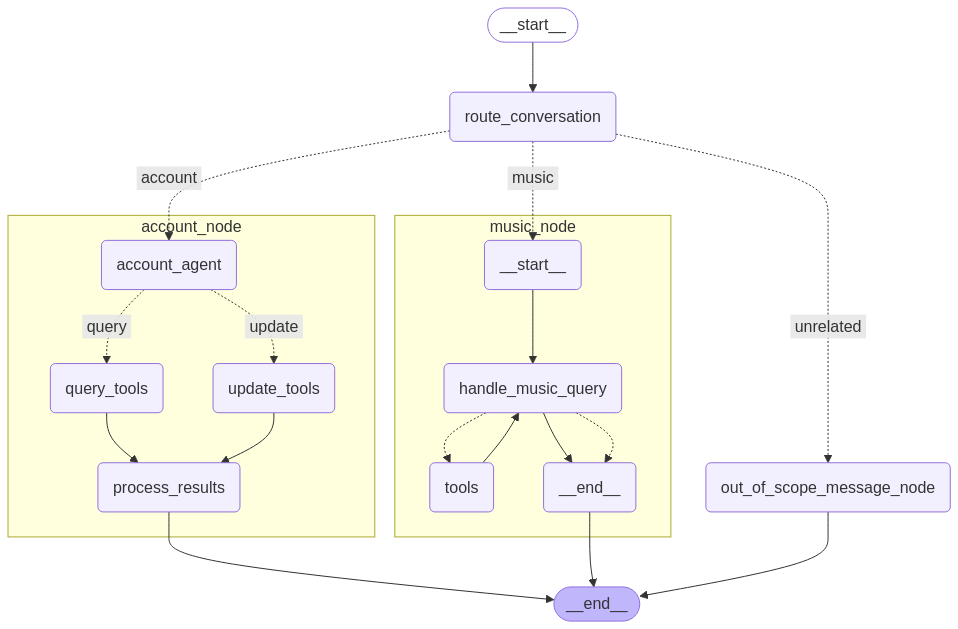

In [34]:
display(Image(front_desk_graph.get_graph(xray=True).draw_mermaid_png()))

## Test

In [35]:
thread_config = {"configurable": {"thread_id": "31-1"}}

response = front_desk_graph.invoke(
    {
        "messages": [HumanMessage(content="Hey, my customer ID is 2. Is Boulevard of Broken Dreams available at the store?")],
        "customer_id": None,
        "current_mode": "router"
    },
    thread_config
)

for m in response["messages"]:
    m.pretty_print()


response = front_desk_graph.invoke(
    {
        "messages": [HumanMessage(content="Based on my purchase history, how would you describe my taste in music?")],
        "customer_id": None,
        "current_mode": "router"
    },
    thread_config
)

for m in response["messages"]:
    m.pretty_print()

~~~~~~~ in route_conversation with state: {'messages': [HumanMessage(content='Hey, my customer ID is 2. Is Boulevard of Broken Dreams available at the store?', additional_kwargs={}, response_metadata={}, id='9cc6eb74-6217-4a91-bd0f-3d71a5786bc9')], 'customer_id': None, 'current_mode': 'router'}
2
--------------------------------------------------
query_customer_info called with 2


/var/folders/h0/6_6mqq755ks82f6p8nvrzqlr0000gn/T/ipykernel_6253/1045262618.py:47: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  if derived_id.isdigit() and query_customer_info({"customer_id": int(derived_id)}) != "":


================================ Human Message =================================

Hey, my customer ID is 2. Is Boulevard of Broken Dreams available at the store?
================================ System Message ================================

Request classified as `music`
================================== Ai Message ==================================
Tool Calls:
  search_songs (call_uXa5N2NSMV8ve7succlv5DfB)
 Call ID: call_uXa5N2NSMV8ve7succlv5DfB
  Args:
    song_title: Boulevard of Broken Dreams
================================= Tool Message =================================
Name: search_songs

[{"Title": "Boulevard Of Broken Dreams", "TrackId": 1136}, {"Title": "Infinite Dreams", "TrackId": 1372}, {"Title": "Dream Of Mirrors", "TrackId": 1240}, {"Title": "Dream Of Mirrors", "TrackId": 1362}]
================================== Ai Message ==================================
Tool Calls:
  check_track_purchase_history (call_1iWYn0uua3MjIKxXciNLiFcf)
 Call ID: call_1iWYn0uua3MjIKxXciNLi

In [36]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "32"}}

# Then use it in your invoke call
response = front_desk_graph.invoke(
    {"messages": [HumanMessage(content="What is the meaning of life?")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

for m in response["messages"]:
    m.pretty_print()

~~~~~~~ in route_conversation with state: {'messages': [HumanMessage(content='What is the meaning of life?', additional_kwargs={}, response_metadata={}, id='a898473d-fb2a-48fc-ace9-7e898fb1e20d')], 'customer_id': None, 'current_mode': 'router'}
UNKNOWN
================================ Human Message =================================

What is the meaning of life?


In [37]:
# Input
initial_input = {
    "messages": [HumanMessage(content="Hey, my customer ID is 2. Please update my email to l@k.com")], 
    "current_mode": "router", 
    "customer_id": None
}

# Thread
thread = {"configurable": {"thread_id": "33"}}

# Run the graph until the first interruption
for event in front_desk_graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in front_desk_graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Hey, my customer ID is 2. Please update my email to l@k.com
~~~~~~~ in route_conversation with state: {'messages': [HumanMessage(content='Hey, my customer ID is 2. Please update my email to l@k.com', additional_kwargs={}, response_metadata={}, id='7654f5ce-47ae-43cb-9a84-330e05fea589')], 'customer_id': None, 'current_mode': 'router'}
2
--------------------------------------------------
query_customer_info called with 2
================================ System Message ================================

Request classified as `account`
================================== Ai Message ==================================

I couldn't process your request. Please try again.


Do you want to call the tool? (yes/no):  yes


================================== Ai Message ==================================

I couldn't process your request. Please try again.


In [38]:
thread_config = {"configurable": {"thread_id": "34"}}

response = front_desk_graph.invoke(
    {
        "messages": [HumanMessage(content="Hey, my customer ID is 2. Please show me my details")], 
        "current_mode": "router", 
        "customer_id": None
    }, 
    thread_config
)

for m in response["messages"]:
    m.pretty_print()

~~~~~~~ in route_conversation with state: {'messages': [HumanMessage(content='Hey, my customer ID is 2. Please show me my details', additional_kwargs={}, response_metadata={}, id='f215f64e-a737-41ad-a611-3f00f6a70e1b')], 'customer_id': None, 'current_mode': 'router'}
2
--------------------------------------------------
query_customer_info called with 2
================================ Human Message =================================

Hey, my customer ID is 2. Please show me my details
================================ System Message ================================

Request classified as `account`
================================== Ai Message ==================================

I'll help you check your account details. Let me retrieve that information for you.
================================== Ai Message ==================================

I couldn't process your request. Please try again.


# New Execution Logic

In [39]:
def run_agent_with_interruption_handling(graph, initial_input, thread_config):
    """
    Run an agent graph with elegant handling of multiple possible interruptions.
    
    Args:
        graph: The compiled LangGraph to run
        initial_input: The initial state to provide to the graph
        thread_config: Thread configuration dictionary
    
    Returns:
        The final response from the graph
    """
    current_input = initial_input
    all_messages = initial_input.get("messages", [])
    
    while True:
        
        for event in graph.stream(current_input, thread_config, stream_mode="values"):

            # Add new messages to our collection and display them
            if 'messages' in event and event['messages']:
                new_messages = [msg for msg in event['messages'] if msg not in all_messages]
                all_messages = event['messages']
                
                for msg in new_messages:
                    msg.pretty_print()

        # Get the state to check for completion or interruption
        state = graph.get_state(thread_config)
        
        # Check if the graph completed execution
        if state.next == ():
            print("\n✅ Graph execution completed successfully")
            return all_messages

        # If we're here, there might be an interruption
        if state.tasks and any(task.interrupts for task in state.tasks):
            # Find the first task with interrupts
            interrupt_task = next(task for task in state.tasks if task.interrupts)
            interrupt_message = interrupt_task.interrupts[0].value
            node_name = interrupt_task.name
            
            print(f"\n⚠️ Graph interrupted at node '{node_name}': {interrupt_message}")
            
            # Handle the interruption based on its type
            interrupt_handler = identify_interrupt_handler(interrupt_message, node_name)
            
            if interrupt_handler:
                # Use the handler to update the state and get new input (if any)
                current_input = interrupt_handler(graph, state, thread_config, interrupt_message)
            else:
                print(f"❌ Unknown interruption type: {interrupt_message}")
                print(state)
                return all_messages
        else:
            # If no tasks with interrupts but graph didn't reach END,
            # something else might be wrong
            print(f"❌ Graph execution stopped unexpectedly")
            print(state.tasks)
            print(state.next)
            return all_messages

def identify_interrupt_handler(interrupt_message, node_name=None):
    """
    Identify the appropriate handler function based on the interruption message.
    
    Args:
        interrupt_message: The message from the interruption
    
    Returns:
        The handler function or None if no matching handler is found
    """
    if interrupt_message == customer_id_interrupt_message:
        return handle_customer_id_interrupt
    elif interrupt_message == action_confirmation_interrupt_message:
        return handle_confirmation_interrupt
    else:
        print(f"!!!!! Unindentified interrupt message {interrupt_message}")
        return handle_generic_interrupt

def handle_customer_id_interrupt(graph, state, thread_config, interrupt_message):
    """Handle interruption requesting customer ID."""
    customer_id_input = input(f"\n🔍 {interrupt_message}")
    
    # Validate input
    if customer_id_input.isdigit():
        # Update the state with the provided customer ID
        new_messages = state.values["messages"] + [
            HumanMessage(content=f"My customer ID is {customer_id_input}")
        ]
        
        graph.update_state(
            thread_config,
            {
                # "customer_id": int(customer_id_input),
                "customer_id": state.values.get("customer_id"),
                "current_mode": state.values.get("current_mode", "account"),
                "messages": new_messages
            }
        )
        
        # No new input needed, just continue with the updated state
        return None
    else:
        print(f"\n🔍 {interrupt_message}. Please enter a valid numeric ID.")
        # Recursively call this handler again
        return handle_customer_id_interrupt(graph, state, thread_config, interrupt_message)

def handle_confirmation_interrupt(graph, state, thread_config, interrupt_message):
    """Handle interruption requesting confirmation for action."""
    confirmation = input(f"\n{interrupt_message} (yes/no): \n").lower()
    
    if confirmation in ("yes", "y"):
        # Add confirmation message to the conversation
        new_messages = state.values["messages"] + [
            HumanMessage(content="Yes, I confirm.")
        ]
        
        graph.update_state(
            thread_config,
            {
                "messages": new_messages,
                "current_mode": state.values.get("current_mode"),
                "customer_id": state.values.get("customer_id")
            }
        )
        return None
    else:
        # Add rejection message to the conversation
        new_messages = state.values["messages"] + [
            HumanMessage(content="No, I don't want to proceed with this.")
        ]
        
        graph.update_state(
            thread_config,
            {
                "messages": new_messages,
                "current_mode": state.values.get("current_mode"),
                "customer_id": state.values.get("customer_id")
            }
        )
        return None

def handle_generic_interrupt(graph, state, thread_config, interrupt_message):
    """Handle any other type of interruption generically."""
    print(f"\n⚠️ {interrupt_message}")
    
    user_response = input(f"\n{interrupt_message} \nYour response: ")
    
    new_messages = state.values["messages"] + [
        HumanMessage(content=user_response)
    ]
    
    graph.update_state(
        thread_config,
        {
            "messages": new_messages,
            "current_mode": state.values.get("current_mode"),
            "customer_id": state.values.get("customer_id")
        }
    )
    return None

In [40]:
initial_input = {
    "messages": [HumanMessage(content="I want to update my account email to test@this-1.com")], 
    "current_mode": "account", 
    "customer_id": None
}

# Define thread
thread = {"configurable": {"thread_id": "multi_interrupt_demo-16"}}

# Run with interrupt handling
final_messages = run_agent_with_interruption_handling(
    front_desk_graph,
    initial_input,
    thread
)

~~~~~~~ in route_conversation with state: {'messages': [HumanMessage(content='I want to update my account email to test@this-1.com', additional_kwargs={}, response_metadata={}, id='908f206b-9a1f-49d6-8258-9deceb7ec310')], 'customer_id': None, 'current_mode': 'account'}
UNKNOWN

⚠️ Graph interrupted at node 'route_conversation': Please provide your customer ID to help me assist you better.



🔍 Please provide your customer ID to help me assist you better. 12


================================ Human Message =================================

My customer ID is 12
~~~~~~~ in route_conversation with state: {'messages': [HumanMessage(content='I want to update my account email to test@this-1.com', additional_kwargs={}, response_metadata={}, id='908f206b-9a1f-49d6-8258-9deceb7ec310'), HumanMessage(content='My customer ID is 12', additional_kwargs={}, response_metadata={}, id='8d6d8aa7-8844-41d3-b2fa-df76da408f4c')], 'current_mode': 'account'}
12
--------------------------------------------------
query_customer_info called with 12
================================ System Message ================================

Request classified as `account`
================================== Ai Message ==================================

I'll help you update your email address to test@this-1.com. Let me process that change for you.
================================== Ai Message ==================================

I couldn't process your request. Please try again.



In [41]:
query_customer_info({"customer_id": 2})

--------------------------------------------------
query_customer_info called with 2


"[(2, 'Leonie', 'Köhler', None, 'Theodor-Heuss-Straße 34', 'Stuttgart', None, 'Germany', '70174', '+49 0711 2842222', None, 'test@this.com', 5)]"